In [ ]:
import pandas as pd

data = pd.read_excel("GAIA IA v.1.3.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

In [14]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(5):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
all_results = []

def train_data(X, y, shapeX, shapeY, nsize1, nsize2, lr, epochs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1, shapeY), dtype=torch.float32) #1 ->4
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values.reshape(-1, shapeY), dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    class RegressionModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
            nn.Linear(shapeX, nsize1),
            nn.ReLU(),
            nn.Linear(nsize1, nsize2), 
            nn.ReLU(),
            nn.Linear(nsize2, shapeY)  
        )

        def forward(self, x):
            return self.net(x)

    model = RegressionModel()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_values = []

    for epochs in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        loss_values.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = criterion(predictions, y_test_tensor)
        mae = torch.mean(torch.abs(predictions - y_test_tensor))
        r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
        print(f"MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")
        
    return loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2

In [17]:
def plot_loss(loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

In [18]:
def plot_compare(predictions, y_test_tensor, tittle, targets):

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for i, ax in enumerate(axs.ravel()):
        if i >= len(targets):
            break
        actual = y_test_tensor[:, i].numpy()
        pred = predictions[:, i].numpy()
        ax.plot(actual, label='Actual', color='blue')
        ax.plot(pred, label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{targets[i]}: Actual vs Predicted')
        ax.set_ylabel(targets[i])
        ax.grid(True)
        ax.legend()

    for i in range(len(targets), len(axs.ravel())):
        fig.delaxes(axs.ravel()[i])
    fig.suptitle(f'Actual vs Predicted {tittle}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=5, features=''):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss()(predictions, y_test_tensor).item()
        mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()        

    y_true = y_test_tensor.numpy().flatten()
    y_pred = predictions.numpy().flatten()

    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': y_pred - y_true
    })

    print(f"Evaluation Results:\n - MSE: {mse:.4f}\n - MAE: {mae:.4f} \n - R2: {r2.item():.4f}")
    print("\nExample predictions:")
    print(results_df.head(n))
    results = []
    results.append({
        'Model': features, 
        'MSE': mse,
        'MAE': mae,
        'R2': r2.item()
    })

    return pd.DataFrame(results)

MSE: 0.6697, MAE: 0.4532 R2: 0.9943


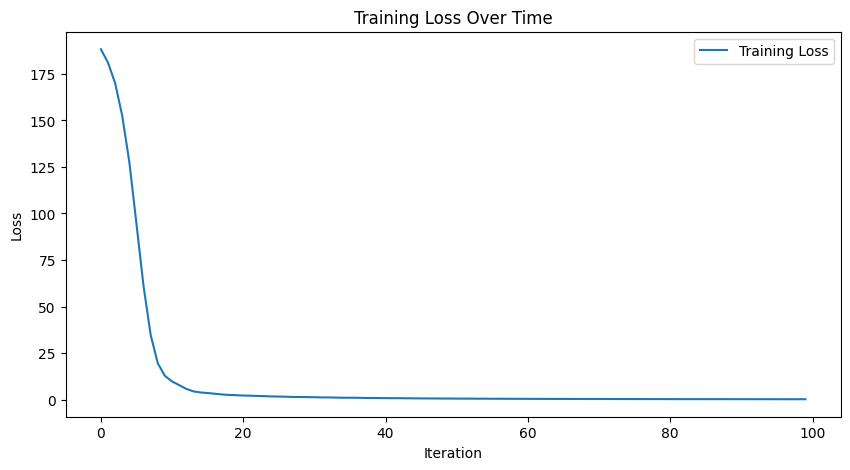

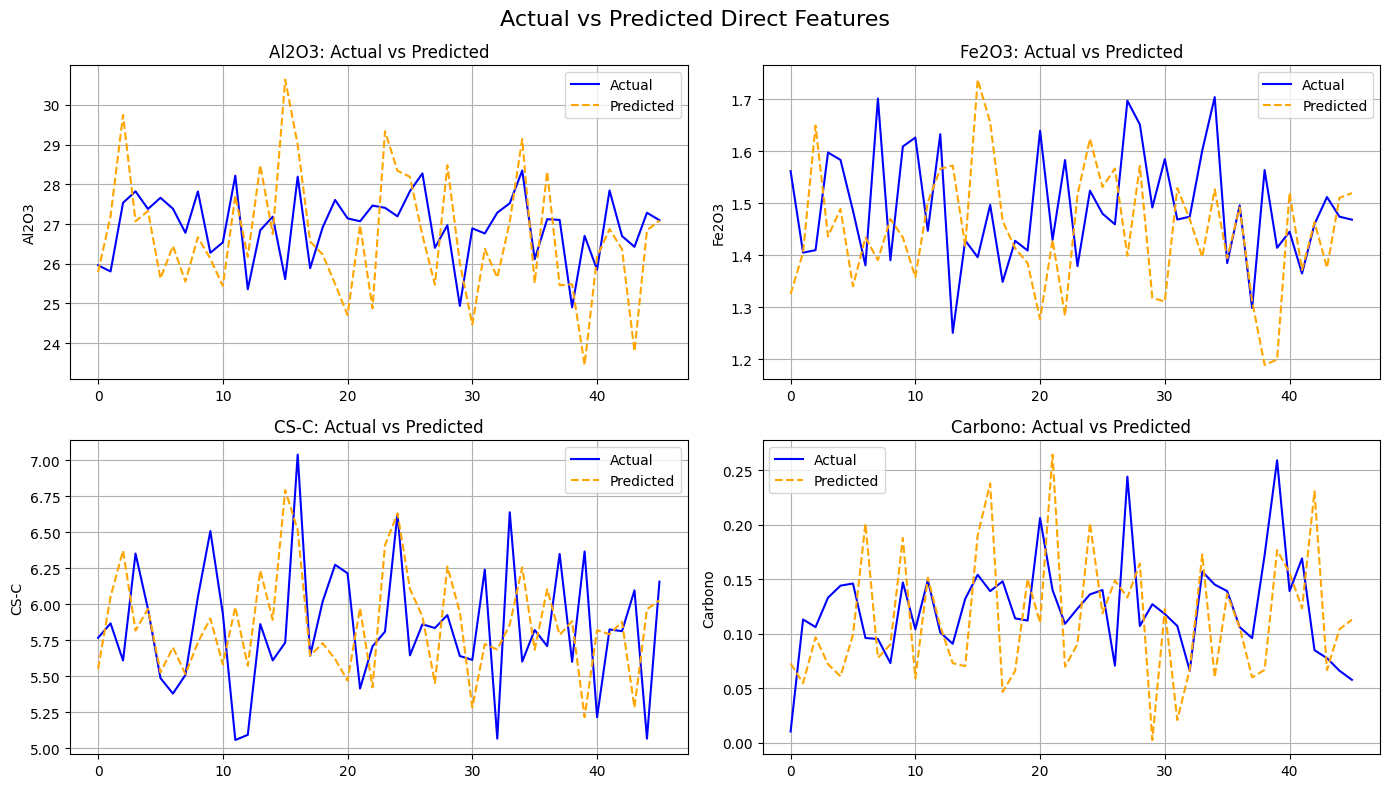

Evaluation Results:
 - MSE: 0.6697
 - MAE: 0.4532 
 - R2: 0.9943

Example predictions:
      Actual  Predicted     Error
0  25.960688  25.787611 -0.173077
1   1.561302   1.324624 -0.236678
2   5.767001   5.551818 -0.215183
3   0.010200   0.072650  0.062450
4  25.805275  27.200298  1.395023
5   1.404642   1.404587 -0.000055
6   5.867491   6.052084  0.184593
7   0.113000   0.054537 -0.058463
8  27.533176  29.743584  2.210407
9   1.409339   1.648884  0.239545


In [20]:
targets = ['Al2O3', 'Fe2O3', 'CS-C', 'Carbono']
y = data[['Al2O3.5', 'Fe2O3.5', 'CS-C.5', 'Carbono.5']]
X = data.drop(columns=['Al2O3.5', 'Fe2O3.5', 'CS-C.5', 'Carbono.5'])
loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'Direct Features', targets)
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features = 'All Features')
all_results.append(results)

MSE: 0.7899, MAE: 0.4494 R2: 0.9948


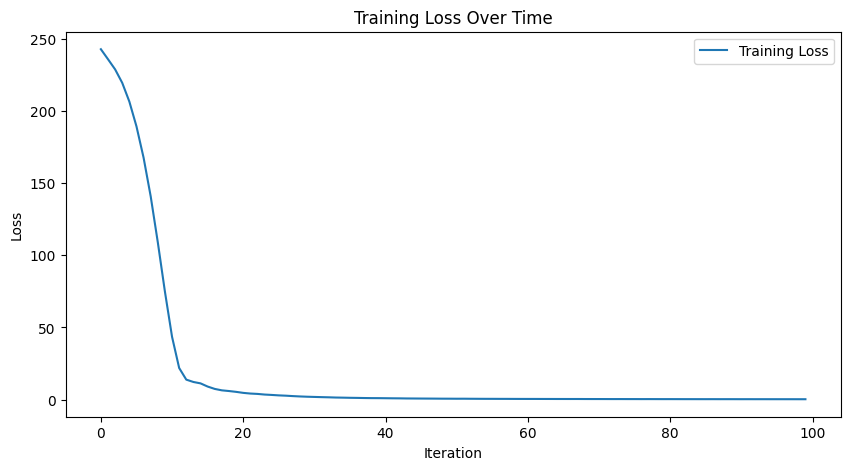

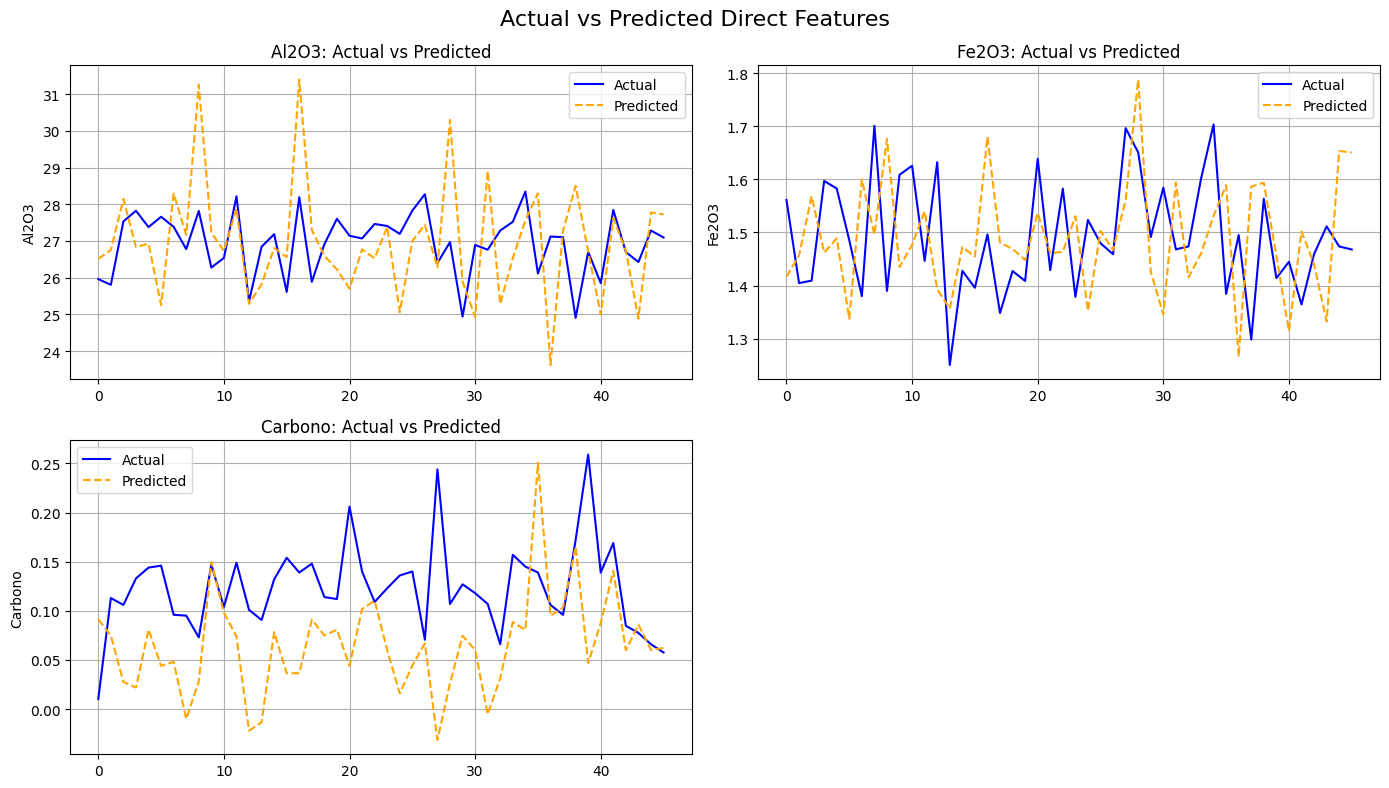

Evaluation Results:
 - MSE: 0.7899
 - MAE: 0.4494 
 - R2: 0.9948

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.513441  0.552753
1   1.561302   1.416912 -0.144390
2   0.010200   0.091356  0.081156
3  25.805275  26.753328  0.948053
4   1.404642   1.456650  0.052008
5   0.113000   0.074806 -0.038194
6  27.533176  28.145647  0.612471
7   1.409339   1.568241  0.158902
8   0.106000   0.027521 -0.078479
9  27.822983  26.832144 -0.990839


In [21]:
targets = ['Al2O3', 'Fe2O3', 'Carbono']
y = data[['Al2O3.5', 'Fe2O3.5','Carbono.5']]
X = data.filter(regex='^Al2O3|^Fe2O3|^Carbono|^%')
X = X.drop(columns=['Al2O3.5', 'Fe2O3.5', 'Carbono.5'])
loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'Direct Features', targets)
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Direct Features')
all_results.append(results)

## Direct features 1 by 1

MSE: 0.8457, MAE: 0.7710 R2: -0.2104


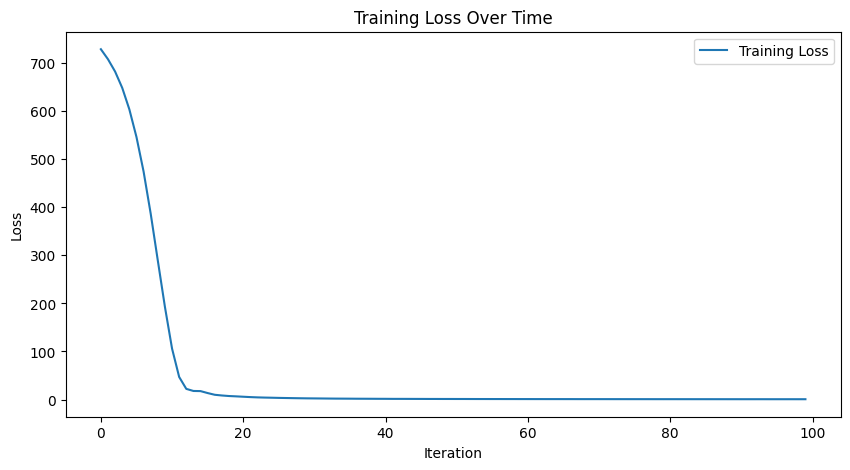

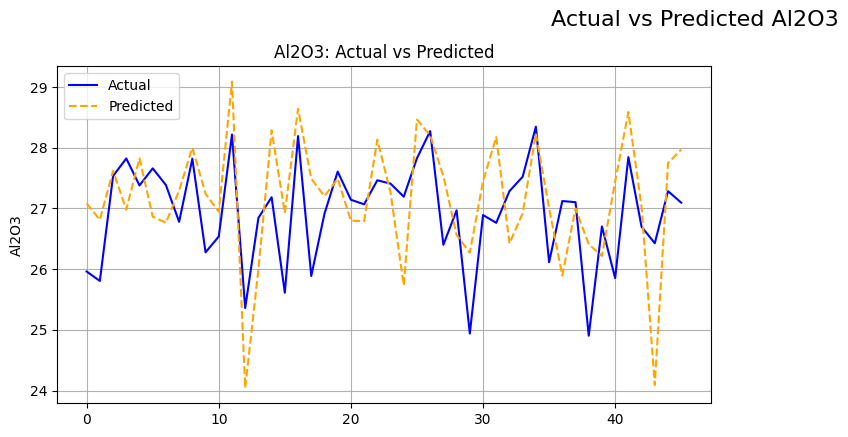

Evaluation Results:
 - MSE: 0.8457
 - MAE: 0.7710 
 - R2: -0.2104

Example predictions:
      Actual  Predicted     Error
0  25.960688  27.081867  1.121180
1  25.805275  26.812689  1.007414
2  27.533176  27.618307  0.085131
3  27.822983  26.980061 -0.842922
4  27.378498  27.827072  0.448574
5  27.660057  26.865271 -0.794786
6  27.385485  26.763948 -0.621536
7  26.778746  27.292845  0.514099
8  27.819937  28.001711  0.181774
9  26.276518  27.242067  0.965549


In [22]:
y = data[['Al2O3.5']]
X = data.filter(regex='^Al2O3|^%')
X = X.drop(columns=['Al2O3.5'])

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'Al2O3', ['Al2O3'])
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Al203')
all_results.append(results)

MSE: 0.0142, MAE: 0.0954 R2: -0.2388


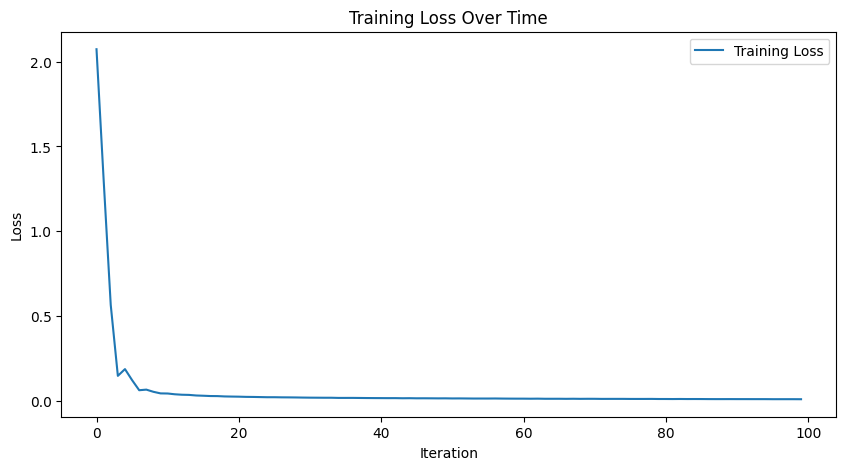

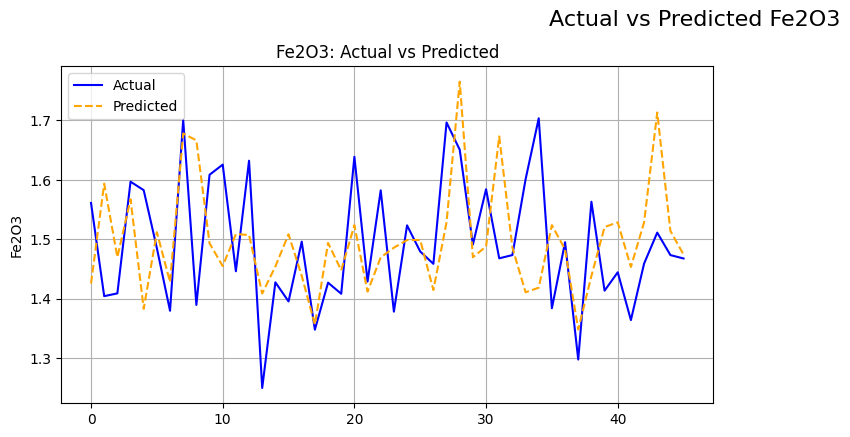

Evaluation Results:
 - MSE: 0.0142
 - MAE: 0.0954 
 - R2: -0.2388

Example predictions:
     Actual  Predicted     Error
0  1.561302   1.425971 -0.135331
1  1.404642   1.593702  0.189060
2  1.409339   1.470227  0.060888
3  1.597123   1.567605 -0.029518
4  1.582867   1.383425 -0.199442
5  1.485325   1.512187  0.026862
6  1.380088   1.428405  0.048316
7  1.700930   1.678235 -0.022695
8  1.389911   1.666521  0.276610
9  1.608766   1.493531 -0.115235


In [23]:
y = data[['Fe2O3.5']]
X = data.filter(regex='^Fe2O3|^%')
X = X.drop(columns='Fe2O3.5')

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'Fe2O3', ['Fe2O3'])
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Fe203')
all_results.append(results)

MSE: 0.2304, MAE: 0.3861 R2: -0.2399


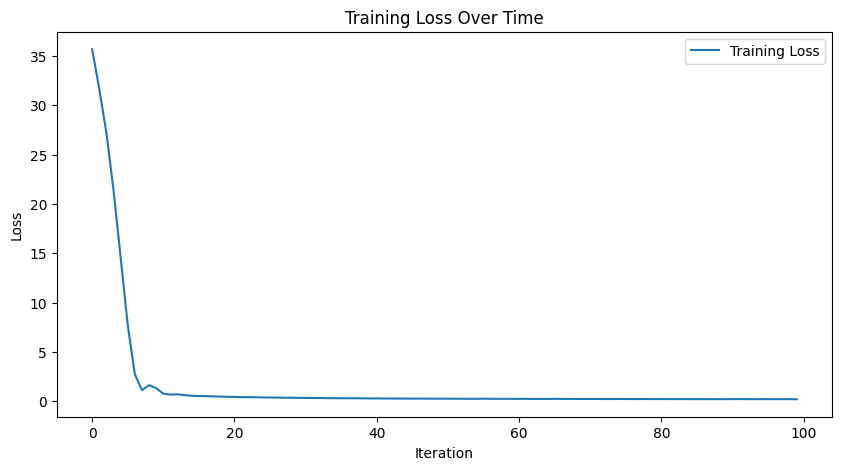

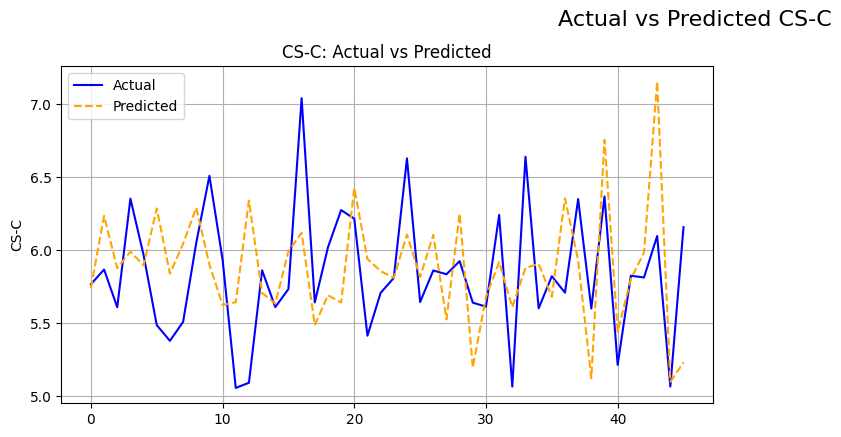

Evaluation Results:
 - MSE: 0.2304
 - MAE: 0.3861 
 - R2: -0.2399

Example predictions:
     Actual  Predicted     Error
0  5.767001   5.741255 -0.025746
1  5.867491   6.235013  0.367522
2  5.609652   5.876245  0.266593
3  6.352685   5.990311 -0.362374
4  5.966827   5.895746 -0.071081
5  5.487041   6.285584  0.798542
6  5.379423   5.838470  0.459047
7  5.509121   6.044192  0.535071
8  6.050461   6.291883  0.241422
9  6.509033   5.900895 -0.608138


In [24]:
y = data[['CS-C.5']]
X = data.filter(regex='^CS-C|^%')
X = X.drop(columns='CS-C.5')

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'CS-C', ['CS-C'])
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='CS-C')
all_results.append(results)

MSE: 0.0020, MAE: 0.0361 R2: -0.0418


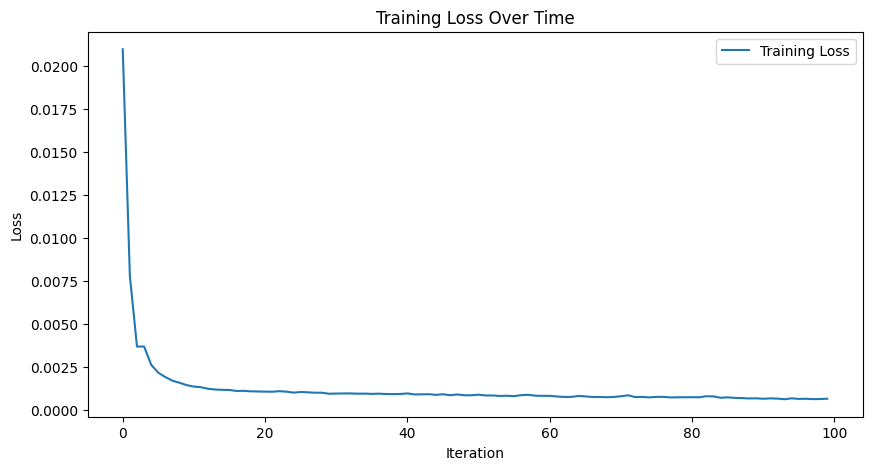

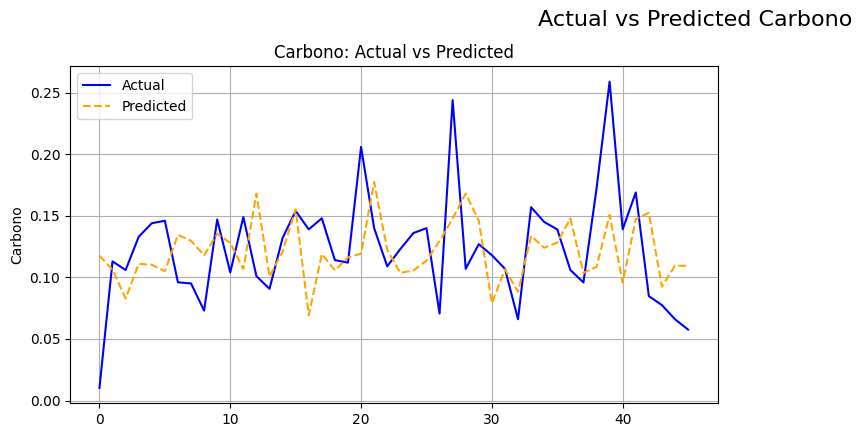

Evaluation Results:
 - MSE: 0.0020
 - MAE: 0.0361 
 - R2: -0.0418

Example predictions:
   Actual  Predicted     Error
0  0.0102   0.117687  0.107487
1  0.1130   0.106246 -0.006754
2  0.1060   0.082891 -0.023109
3  0.1330   0.110931 -0.022069
4  0.1440   0.110307 -0.033693
5  0.1460   0.105084 -0.040916
6  0.0960   0.134463  0.038463
7  0.0951   0.129754  0.034654
8  0.0730   0.117905  0.044905
9  0.1470   0.135375 -0.011625


In [25]:
y = data[['Carbono.5']]
X = data.filter(regex='^Carbono|^%')
X = X.drop(columns='Carbono.5')

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, X.shape[1], y.shape[1], 64, 32, 0.002, 100)
plot_loss(loss_values)
plot_compare(predictions, y_test_tensor, 'Carbono', ['Carbono'])
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Carbono')
all_results.append(results)

In [26]:
final_results_df = pd.concat(all_results, ignore_index=True)

print("\nFinal Results:")
from IPython.display import display
display(final_results_df)


Final Results:


,Model,MSE,MAE,R2
0,All Features,0.669690,0.453211,0.994269
1,Direct Features,0.789854,0.449448,0.994816
2,Al203,0.845707,0.770987,-0.210380
3,Fe203,0.014151,0.095444,-0.238790
4,CS-C,0.230410,0.386073,-0.239902
5,Carbono,0.002032,0.036104,-0.041799


In [27]:
final_results_df = final_results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)
print("\nSorted Final Results:")
display(final_results_df)


Sorted Final Results:


,Model,MSE,MAE,R2
0,Direct Features,0.789854,0.449448,0.994816
1,All Features,0.669690,0.453211,0.994269
2,Carbono,0.002032,0.036104,-0.041799
3,Al203,0.845707,0.770987,-0.210380
4,Fe203,0.014151,0.095444,-0.238790
5,CS-C,0.230410,0.386073,-0.239902
